# 使用卷积神经网络机实现MNIST CNN


我的第二个机器学习案例. 
CNN实现英文手写识别。使用 PyTorch 实现。
本代码实现，没有参考mnist的PyTorch实现，主要参考《神经网络与深度学习》版本中:Michael Nielsen的原理实现。
该书采用手写代码实现，下文采用PyTorch实现。
代码主要参考《madewithml》中文版代码


sanit.peng

# 概览 Overview


$z_2 = XW_1$

$a_2 = f(z_2)$

$z_3 = a_2W_2$

$\hat{y} = softmax(z_3)$ # 类别

*其中*：
* $X$ = 输入 | $\in \mathbb{R}^{NXD}$ ($D$ 是特征的数量)
* $W_1$ = 第1层权重 | $\in \mathbb{R}^{DXH}$ ($H$ 是隐含层在第1层的单元数量)
* $z_2$ = 第1层权重的输出  $\in \mathbb{R}^{NXH}$
* $f$ = 非线性激活函数
* $a_2$ = 应用在第1层输出的激活值 | $\in \mathbb{R}^{NXH}$
* $W_2$ = 第2层权重 | $\in \mathbb{R}^{HXC}$ ($C$ 是类别数量)
* $\hat{y}$ = 预测 | $\in \mathbb{R}^{NXC}$ ($N$ 是采样数量)

这是简单的2层 MLP. 

* **目的：**  基于给定的输入预测类别的概率。因为非线性数据，模型复杂度引入了非线性。
* **优势：**
  * 能很好的处理非线性模式。
* **劣势：**
  * 容易过拟合。
  * 计算精度取决于网络体积。
  * 不容易解释。
* **多样性：** 我们之后看到的未来神经网略架构使用 MLP 作为前馈操作（非线性操作之前的仿射变换）的一个模块单元。

# 训练 Training

*步骤*：$

0. mnist数据装载，将图片数据变为（28*28）= 784个输入的数据， 整个数据组织成[N, 784]的一个2维张量和[N]的一个1维张量存放标签。
    
    模型设计：1个隐藏层30个神经元，随机梯度下降，交叉熵计算损失，未减枝。$
    
    超参数:  学习率3.0
    
    
1. 随机初始化模型权重 $W$ （我们在之后的课程中将介绍更有效的初始化策略）。
2. 给予模型输入 $X$ 得到概率。
3. 比较预测值 $\hat{y}$ 和真实值 $y$ （，使用目标（代价）函数决定损失 $J$。分类任务常用的目标函数是交叉熵损失(Cross Entropy Loss)。 
  * $z_2 = XW_1$
  * $a_2 = max(0, z_2)$ # ReLU 激活函数, Sigmoid 激活函数对最后的识别率影响很大，ReLU大概为20%， Sigmoid为93%
  * $z_3 = a_2W_2$
  * $\hat{y} = softmax(z_3)$
  * $J(\theta) = - \sum_i y_i ln (\hat{y_i}) $
4. 计算损失 $J(\theta)$ w.r.t 对模型权重的梯度。 
   * $ \frac{\partial{J}}{\partial{W_{2j}}} = a_2\hat{y}, \frac{\partial{J}}{\partial{W_{2y}}} = a_2(\hat{y}-1) $
   * $ \frac{\partial{J}}{\partial{W_1}} = \frac{\partial{J}}{\partial{\hat{y}}} \frac{\partial{\hat{y}}}{\partial{a_2}}  \frac{\partial{a_2}}{\partial{z_2}}  \frac{\partial{z_2}}{\partial{W_1}}  = W_2(\partial{scores})(\partial{ReLU})X $
   
5. 应用反向传播法（backpropagation）到使用梯度下降更新权重 $W$ 。这些更新将减少错误类别（j）的概率，增加正确类别（y）的概率。
  * $W_i = W_i - \alpha\frac{\partial{J}}{\partial{W_i}}$
6. 重复步骤2-4，直到模型收敛。

# 数据 Data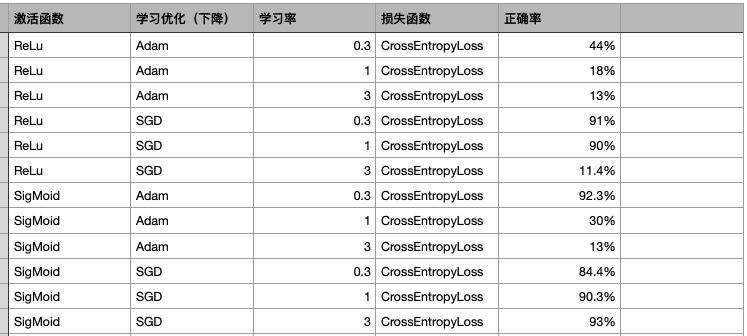
从数据可以看出，激活函数选择，学习路径，和超参数的选择对整个结果有很大影响。当按照《神》一文中选择得到的效果最好93%，但依然无法达到文中所说96%。因此需要：1.理解各种函数和参数选择的方法 2.理解层数（深度）和神经元多少的影响。本文未做实验。
未实验： tanh, 神经元个数，超参数如何选择。。。。$
上图是200次epoch结果，将epoch提高到2000次，成功率98.2% 但不知道是否会过拟合。

# 数据 Data

加载mnist数据

In [62]:
# Load PyTorch library
!pip3 install torch torchvision

In [63]:
#for MacOS
import os 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"




In [64]:
# load mnist data, rewriten from mnist_loader
import pandas as pd 
import pickle

import gzip



def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.

    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.

    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.

    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.

    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open('../data/mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding='bytes')
    f.close()
    return (training_data, validation_data, test_data)



def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.

    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.

    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.

    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e



In [65]:
tr_d, va_d, te_d = load_data()

In [66]:
tr_d

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([5, 0, 4, ..., 8, 4, 8]))

In [67]:
len(tr_d[0][0])

784

In [68]:
type(tr_d[0]),tr_d[0].shape,tr_d[1].shape

(numpy.ndarray, (50000, 784), (50000,))

In [69]:
from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

In [71]:
# Convert to PyTorch tensors
X_train = torch.from_numpy(tr_d[0]).float()
y_train = torch.from_numpy(tr_d[1]).long()

In [72]:
X_train.dim(), y_train.dim()

(2, 1)

In [73]:
X_train.size()

torch.Size([50000, 784])

In [74]:
#图像的CNN,需要保留x,y的图像空间结构，将数据重新组装成[N, 28, 28]的张量

X_train = X_train.view(X_train.size(0), 28, 28)
X_train.size()

torch.Size([50000, 28, 28])

In [75]:
y_train

tensor([5, 0, 4,  ..., 8, 4, 8])

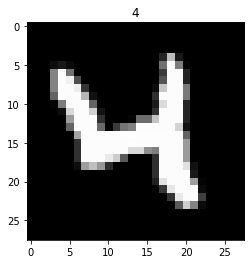

In [76]:
# plot one example
index = 20
plt.imshow(X_train[index].numpy(), cmap='gray')
plt.title('%i' % y_train[index])
plt.show()

In [84]:
# Hyper parameters
# Arguments
args = Namespace(
    num_epochs = 1,
    num_classes = 10,
    batch_size = 100,
    learning_rate = 0.001,    
)


In [85]:
X_CNN_train = X_train[:args.batch_size, ]
y_CNN_train = y_train[:args.batch_size, ]

In [86]:
X_CNN_train.size(), y_CNN_train.size()

(torch.Size([100, 28, 28]), torch.Size([100]))

关于卷积核的kernel_size, stride, padding, 输入输出的大小：这个文档解释的清楚。https://zhuanlan.zhihu.com/p/77471866
简单的描述如下：
关于padding： padding的提出是为了解决图片边缘特征被忽略的问题，因此是加在输入的边缘上，比如对于一个，28x28的图案， padding=2, 左边+2， 右边+2，共32x32的图案。




在卷积时，我们有时候需要卷积前后的尺寸不变。这时候我们就需要用到padding。假设图像的大小，也就是被卷积对象的大小为n*n，卷积核大小为k*k，padding的幅度设为(k-1)/2时，卷积后的输出就为(n-k+2*((k-1)/2))/1+1=n，即卷积输出为n*n，保证了卷积前后尺寸不变。但是如果k是偶数的话，(k-1)/2就不是整数了。

本文中，保持卷积层输出为28x28, kernal_size=5， padding=(5-1)/2=2, 卷积输出：（28-5+2*(padding))/1 + 1 = 28

关于Stride: 卷积过程中，有时需要通过padding来避免信息损失，有时也要在卷积时通过设置的步长（Stride）来压缩一部分信息，或者使输出的尺寸小于输入的尺寸。简单来讲，Stride的作用：是成倍缩小尺寸，而这个参数的值就是缩小的具体倍数，比如步幅为2，输出就是输入的1/2；步幅为3，输出就是输入的1/3。以此类推。
（practicalAI代码注释中，对Padding, Stride的理解有误。sanit.peng）

另外参考https://www.jianshu.com/p/f995a9f86aec
https://www.freesion.com/article/8111286641/
说明n个卷积核，及提取的n特征图的情况

特征图的数量理解（个人理解）：
nn.Conv2d.out_channels 就是卷积核的个数，因为卷积核的个数=特征图的个数，所以， out_channels=特征图的个数

卷积核数目一般都是取2的整数次方，感觉并没有太多trick，具体多少要看效果了。

一句话说就是，特征图的数量太少模型拟合能力不够容易欠拟合，反之，特征图数量过多，容易模型拟合能力很强，参数量参加，容易导致过拟合。所以不能太多，也不能太少

特征图另一个问题：
特征图的大小和输入图的关系：
一般来说， 如果特征图的大小减半，那么特征图的个数就要增加1倍，避免丢失太多的信息。
在本文中，原代码关于第二层的输入注释是错误的，所以关系无法理解。
正确理解：
输入层[1，28， 28] --->第一层卷积+池化--->[16, 14, 14],
那么第二层，因为经过2x2的池化，特征图输出会变成7x7, 按照上面原则，将特征图数量变为32
所以才有第2层参数的设计

经过2层后1张28x28的图变成了32张7x7的特征图，虽然有了更多的特征图，但因为特征图对多张输入来说（？？？是否是我理解这样）共享了权重和偏置，所以实际的参数更少，计算效率也更高。


特征图的问题：卷积核比如5x5的卷积核，一共有25种，那么当我们取2^4 = 16的时候，取哪16种呢？是否和最后的有关系？？

In [103]:
# Multilayer Perceptron 
class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()

        #定义第1层卷积层
        #第一层，每个卷积的输入是一个[1, 28, 28]的图形（一张图）， 张量[1, 28, 28]
        #输出 [16, 28, 28]图-->池化后--->[16, 14, 14]
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        
        #定义第2层卷积层
        #每个卷积的输入是一个[16, 14, 14]的特征图（16张图）
        #输出 [32, 7, 7]图-->池化后--->[32, 7, 7]， 32张特征图
        
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(
                in_channels=16,              # input height
                out_channels=32,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2
            ),                              # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (32, 7, 7)
        )

        #32x7x7的全连接
        self.out = nn.Linear(32 * 7 * 7, args.num_classes)   # fully connected layer, output 10 classes
        

    def forward(self, x):        
        x = self.conv1(x)
        x = self.conv2(x)
        #所以，这里的x应该是 [N, 32, 7, 7]的一个张量， 变成一个全连接的输入， [N, 32*7*7]
        #print(x.size())
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization        
        


In [104]:
# Initialize model

model = ConvNN()
print(model)  # net architecture

ConvNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [105]:
# Optimization,
#损失函数 和 学习路径
loss_fn = nn.CrossEntropyLoss()


In [106]:
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate) # Adam optimizer (usually better than SGD)


In [107]:
#损失函数 和 学习路径SGD
#optimizer = optim.SGD(model.parameters(), lr=args.learning_rate) # SGD optimizer (usually better than SGD)


In [108]:
#由于神经网络要求图片四维——数量×通道数×长×宽
#需要扩展维度

train_loader = X_CNN_train.unsqueeze(1)
labels = y_CNN_train

train_loader.size(), labels.size()


(torch.Size([100, 1, 28, 28]), torch.Size([100]))

In [109]:




# Train the model
total_step = len(train_loader)
for epoch in range(args.num_epochs):
    for i in range(total_step):
        
        # Forward pass
        outputs, _= model(train_loader)
        loss = loss_fn(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, args.num_epochs, i+1, total_step, loss.item()))


Epoch [1/5], Step [100/100], Loss: 0.0013
Epoch [2/5], Step [100/100], Loss: 0.0005
Epoch [3/5], Step [100/100], Loss: 0.0002
Epoch [4/5], Step [100/100], Loss: 0.0001
Epoch [5/5], Step [100/100], Loss: 0.0001


In [452]:
# Accuracy
def get_accuracy(y_pred, y_target):
    n_correct = torch.eq(y_pred, y_target).sum().item()
    accuracy = n_correct / len(y_pred) * 100
    return accuracy

In [453]:
# Training
for t in range(args.num_epochs):
    # Forward pass
    y_pred = model(X_train)
    
    # Accuracy
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

    # Loss
    loss = loss_fn(y_pred, y_train)
    
    # Verbose
    if t%20==0: 
        print ("epoch: {0:02d} | loss: {1:.4f} | acc: {2:.1f}%".format(
            t, loss, accuracy))

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

epoch: 00 | loss: 2.3302 | acc: 10.3%
epoch: 20 | loss: 0.7914 | acc: 78.9%
epoch: 40 | loss: 0.5351 | acc: 82.1%
epoch: 60 | loss: 0.3766 | acc: 89.4%
epoch: 80 | loss: 0.3277 | acc: 90.9%
epoch: 100 | loss: 0.3024 | acc: 91.4%
epoch: 120 | loss: 0.2863 | acc: 91.8%
epoch: 140 | loss: 0.2672 | acc: 92.4%
epoch: 160 | loss: 0.2526 | acc: 92.8%
epoch: 180 | loss: 0.2414 | acc: 93.2%
epoch: 200 | loss: 0.2318 | acc: 93.4%
epoch: 220 | loss: 0.2233 | acc: 93.7%
epoch: 240 | loss: 0.2157 | acc: 93.9%
epoch: 260 | loss: 0.2087 | acc: 94.1%
epoch: 280 | loss: 0.2023 | acc: 94.2%
epoch: 300 | loss: 0.1965 | acc: 94.4%
epoch: 320 | loss: 0.1911 | acc: 94.5%
epoch: 340 | loss: 0.1860 | acc: 94.7%
epoch: 360 | loss: 0.1813 | acc: 94.8%
epoch: 380 | loss: 0.1769 | acc: 94.9%
epoch: 400 | loss: 0.1727 | acc: 95.1%
epoch: 420 | loss: 0.1688 | acc: 95.2%
epoch: 440 | loss: 0.1651 | acc: 95.3%
epoch: 460 | loss: 0.1616 | acc: 95.4%
epoch: 480 | loss: 0.1582 | acc: 95.5%
epoch: 500 | loss: 0.1551 | ac

In [454]:
# Predictions
_, pred_train = model(X_train, apply_softmax=True).max(dim=1)


In [455]:
# Train and test accuracies
train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)

print ("train acc: {0:.1f}%".format(train_acc))

train acc: 98.2%


In [456]:
#####################################################################

In [457]:
#开始测试，为了不影响参数执行eval(),当之下train()的时候会继续影响参数
model.eval()

MLP(
  (fc1): Linear(in_features=784, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=10, bias=True)
)

In [458]:
# Convert to PyTorch tensors
X_test = torch.from_numpy(te_d[0]).float()
y_test = torch.from_numpy(te_d[1]).long()

In [459]:
X_test

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [460]:
y_test

tensor([7, 2, 1,  ..., 4, 5, 6])

In [461]:
_, pred_test = model(X_test, apply_softmax=True).max(dim=1)
test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 98.2%, test acc: 96.5%


In [462]:
index = 1

In [463]:
X_test[index].size(), X_test.size()

(torch.Size([784]), torch.Size([10000, 784]))

In [464]:
#X_test[index].unsqueeze(0)
#X_test[index].unsqueeze(0).size()

In [465]:
#去某个测试数据，同时重新扩充为2维张量
test_image = X_test[index].unsqueeze(0)
test_y = y_test[index].unsqueeze(0)

y_pred = model(test_image, apply_softmax=True)

print(y_pred, test_y)



tensor([[1.8817e-05, 8.4252e-05, 9.9749e-01, 2.1069e-03, 1.6197e-08, 2.1615e-04,
         4.3240e-05, 4.1142e-09, 4.4792e-05, 2.4067e-07]],
       grad_fn=<SoftmaxBackward>) tensor([2])


In [466]:
# Top nationality
y_prob, indices = y_pred.max(dim=1)
#index = indices.item()
print(y_prob)
print(indices, indices.item())

probability = y_prob.item()
print('probability', probability)

tensor([0.9975], grad_fn=<MaxBackward0>)
tensor([2]) 2
probability 0.9974855184555054
